In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [6]:
seed =42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 

In [7]:
TRAIN_PATH='/content/drive/My Drive/dents/train'
TEST_PATH='/content/drive/My Drive/dents/test'

train_ids= next(os.walk(TRAIN_PATH))[1]
test_ids= next(os.walk(TEST_PATH))[1]

print(train_ids)

['1', '39', '18', '10', '16', '17', '11', '13', '12', '15', '14', '22', '24', '20', '21', '2', '25', '23', '19', '27', '26', '32', '31', '33', '36', '3', '34', '29', '28', '30', '35', '42', '44', '43', '37', '40', '38', '45', '4', '41', '52', '5', '47', '50', '49', '6', '51', '7', '48', '46', '8', '9']


In [8]:
X_train = np.zeros ((len(train_ids),IMG_HEIGHT,IMG_WIDTH , IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros(( len(train_ids),IMG_HEIGHT,IMG_WIDTH, 1 ),dtype=np.bool)

print ('resizing training images and masks')
for n, id_ in tqdm (enumerate(train_ids), total=len(train_ids)):
     path = TRAIN_PATH + '/' +id_
     for img_file in next(os.walk(path +'/images/'))[2]:
       img = imread(path + '/images/'+img_file)[:,:,:IMG_CHANNELS]
       img= resize (img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
     X_train[n] = img

     for mask_file in next(os.walk(path +'/masks/'))[2]:
       mask = imread(path + '/masks/'+ mask_file)
       mask = resize (mask, (IMG_HEIGHT,IMG_WIDTH,1), mode='constant', preserve_range=True)
     Y_train[n] = mask 
     

  0%|          | 0/52 [00:00<?, ?it/s]

resizing training images and masks


100%|██████████| 52/52 [02:59<00:00,  3.46s/it]


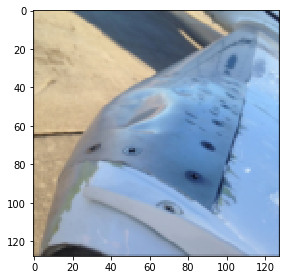

In [9]:
image_x= random.randint(0, len(train_ids))
imshow(np.squeeze(X_train[0]))
plt.show()

In [10]:
#test images

X_test = np.zeros ((len(test_ids),IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test= []

print ('resizing test images')
for n, id_ in tqdm (enumerate(test_ids), total=len(test_ids)):
     path = TEST_PATH + '/' +id_
     img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
     sizes_test.append([img.shape[0], img.shape[1]])
     img= resize (img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
     X_test[n] = img

print('done')

  0%|          | 0/6 [00:00<?, ?it/s]

resizing test images


100%|██████████| 6/6 [00:19<00:00,  3.23s/it]

done


build the model

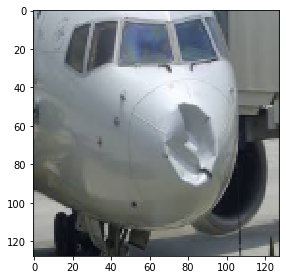

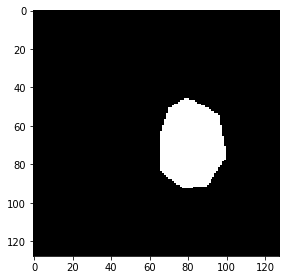

In [13]:
image_x= random.randint(0, len(train_ids))
imshow(np.squeeze(X_train[image_x]))
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

contraction path

In [14]:
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x /255)(inputs)

c1= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(2, 2)(c1)

c2= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(2, 2)(c2)

c3= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(2, 2)(c3)


c4= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(2, 2)(c4)

c5= tf.keras.layers.Conv2D (256 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5= tf.keras.layers.Conv2D (256 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path

u6= tf.keras.layers.Conv2DTranspose (128, (2,2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6= tf.keras.layers.Dropout(0.2)(c6)
c6= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7= tf.keras.layers.Conv2DTranspose (64 ,(2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7= tf.keras.layers.Conv2D (64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7= tf.keras.layers.Dropout(0.2)(c7)
c7= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8= tf.keras.layers.Conv2DTranspose (32 ,(2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8= tf.keras.layers.Dropout(0.2)(c8)
c8= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9= tf.keras.layers.Conv2DTranspose (16 ,(2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1], axis=3)
c9= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9= tf.keras.layers.Dropout(0.2)(c9)
c9= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [15]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_dents.h5', verbose=1, save_best_only=True )

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=15, epochs= 350)

Epoch 1/350
4/4 [==============================] - 35s 468ms/step - loss: 0.7170 - accuracy: 0.4248 - val_loss: 0.6447 - val_accuracy: 0.9395
Epoch 2/350
4/4 [==============================] - 0s 34ms/step - loss: 0.6169 - accuracy: 0.8314 - val_loss: 0.3309 - val_accuracy: 0.9551
Epoch 3/350
4/4 [==============================] - 0s 35ms/step - loss: 0.3589 - accuracy: 0.9430 - val_loss: 0.3769 - val_accuracy: 0.9557
Epoch 4/350
4/4 [==============================] - 0s 34ms/step - loss: 0.2897 - accuracy: 0.9558 - val_loss: 0.2805 - val_accuracy: 0.9557
Epoch 5/350
4/4 [==============================] - 0s 35ms/step - loss: 0.2467 - accuracy: 0.9565 - val_loss: 0.2739 - val_accuracy: 0.9557
Epoch 6/350
4/4 [==============================] - 0s 34ms/step - loss: 0.2388 - accuracy: 0.9565 - val_loss: 0.2546 - val_accuracy: 0.9557
Epoch 7/350
4/4 [==============================] - 0s 35ms/step - loss: 0.2295 - accuracy: 0.9566 - val_loss: 0.2552 - val_accuracy: 0.9557
Epoch 8/350
4/4 [=

1/1 [==============================] - 0s 13ms/step


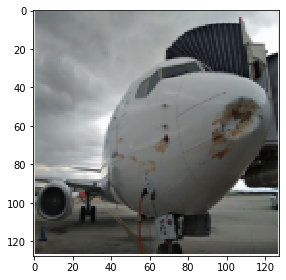

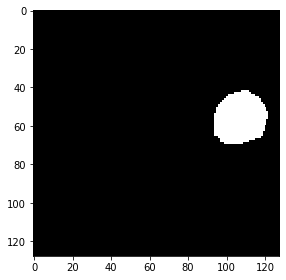

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


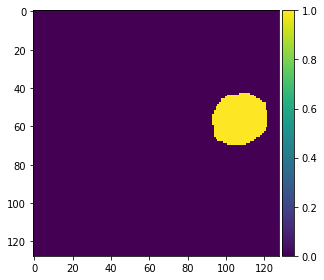

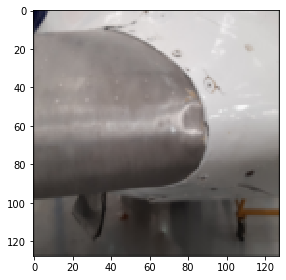

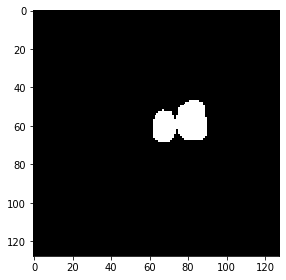

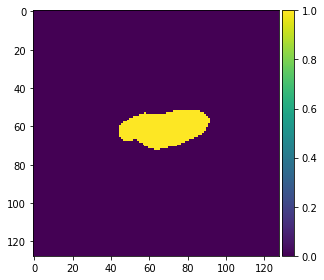

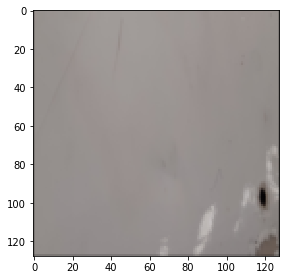

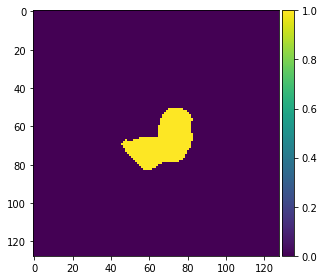

In [17]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test_t))
imshow(X_train[int(X_test.shape[0]*0.9):][ix])
plt.show()
#imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
#plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()


In [18]:
# Save our model as saved_model format
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [19]:
# Covert to Tensorflow Lite format 
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()
open("Unet_testmodel.tflite", "wb").write(tflite_model)

7780292

In [20]:
#test images
Y_test = np.zeros(( len(test_ids),IMG_HEIGHT,IMG_WIDTH, 1 ),dtype=np.bool)
sizes_test= []

print ('resizing test images')
for n, id_ in tqdm (enumerate(test_ids), total=len(test_ids)):
     path = TEST_PATH + '/' +id_
     for mask_file in next(os.walk(path +'/masks/'))[2]:
       mask = imread(path + '/masks/'+ mask_file)
       mask = resize (mask, (IMG_HEIGHT,IMG_WIDTH,1), mode='constant', preserve_range=True)
     Y_test[n] = mask 
print('done')

  0%|          | 0/6 [00:00<?, ?it/s]

resizing test images


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

done


In [21]:
model.evaluate(X_test, Y_test, return_dict= True)

1/1 [==============================] - 0s 23ms/step - loss: 0.1324 - accuracy: 0.9685


{'accuracy': 0.9685160517692566, 'loss': 0.13241064548492432}

In [32]:
m = tf.keras.metrics.Recall()
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.76119405

In [31]:
m = tf.keras.metrics.Precision()
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.3871886

In [26]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.96851605

In [30]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state( Y_test, preds_test, sample_weight=None)
m.result().numpy()

0.48909506